# Customer Segmentation and Seasonal Analysis
This notebook focuses on segmenting customers and analyzing their seasonal shopping behaviors using AI techniques. It builds on previous analyses to extract actionable insights from customer purchase data.

Key steps in this notebook include:
- Loading and preprocessing datasets (`customer.csv`, `order.csv`, and `product.csv`).
- Segmenting customers based on their total spending using K-Means clustering.
- Analyzing product preferences and grouping customers into meaningful categories.
- Identifying seasonal shopping behaviors and clustering customers based on holiday and non-holiday spending patterns.

The analysis utilizes the following datasets:
1. **`customer.csv`**:
   - Contains customer details, including `Customer ID` and demographics.
2. **`order.csv`**:
   - Includes order information such as `Customer ID`, `Order Date`, `Order Amount`, and `Product ID`.
3. **`product.csv`**:
   - Provides product details such as `Product ID`, `Product Category`, and price.

The datasets are loaded into pandas DataFrames for further preprocessing and analysis.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Data Preprocessing
Data preprocessing involves the following steps:
1. Aggregating total spending for each customer.
2. Normalizing spending data using `StandardScaler` to prepare it for clustering.
3. Creating additional features, such as a holiday spending ratio, to enhance segmentation.

These steps ensure that the dataset is clean and suitable for clustering and analysis.

In [ ]:
customer_df = pd.read_csv('./data/processed/customer.csv')
order_df = pd.read_csv('./data/processed/order.csv')
product_df = pd.read_csv('./data/processed/product.csv')


## Elbow Method for Optimal Clusters
- The Elbow Method is applied to identify the optimal number of clusters for customer segmentation.
- The Within-Cluster Sum of Squares (WCSS) is plotted against various cluster counts to locate the "elbow point."

## K-Means Clustering
- K-Means clustering is used to group customers based on their total spending.
- The resulting clusters are labeled as:
  - Low Spenders
  - Moderate Spenders
  - High Spenders
  - Very High Spenders

## Visualization
- Scatter plots are utilized to visualize customer segments, illustrating spending patterns across clusters.

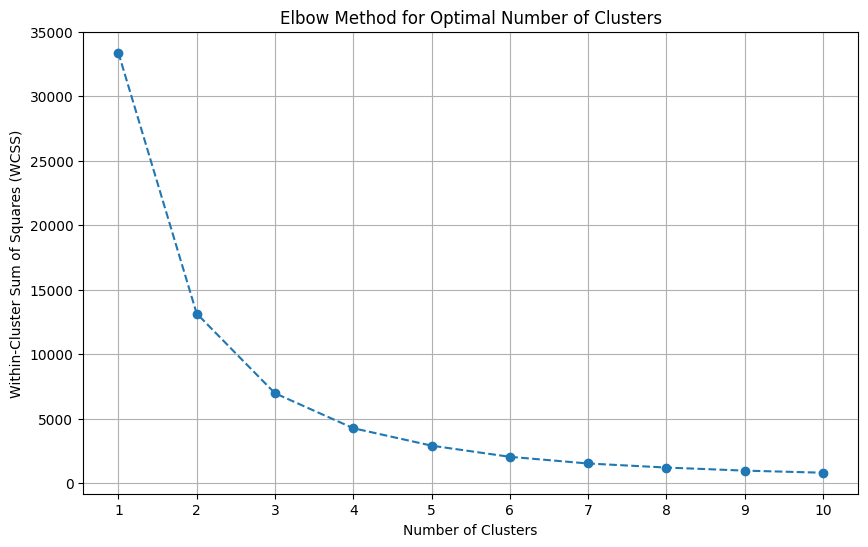

Cluster Centers (Total Spending): [[ 150.38052295]
 [ 942.51345502]
 [1990.62129223]
 [ 450.09656333]]


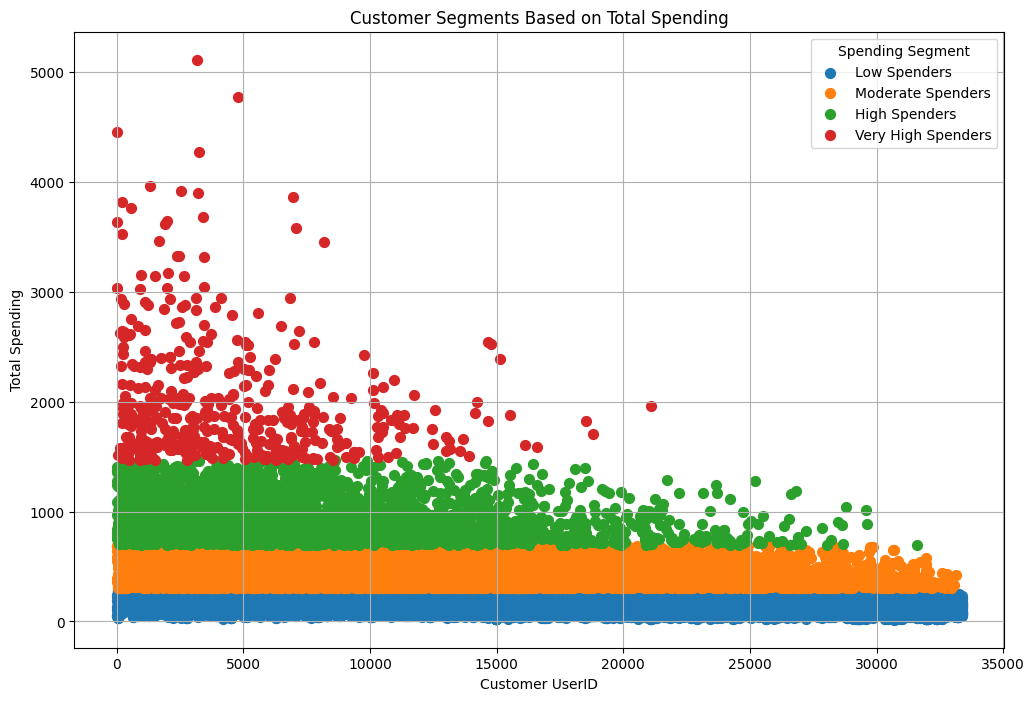

   customer_userid  total_spending  total_spending_scaled  cluster  \
0                0      132.404838              -0.555322        0   
1                1     1405.037557               3.354624        1   
2                2      773.171997               1.413325        1   
3                3     3029.654052               8.345979        2   
4                4     1243.353951               2.857878        1   

     spending_segment  
0        Low Spenders  
1       High Spenders  
2       High Spenders  
3  Very High Spenders  
4       High Spenders  


In [ ]:
# Aggregate total spending per customer
customer_spending = order_df.groupby('customer_userid')['paid_amt'].sum().reset_index()
customer_spending.columns = ['customer_userid', 'total_spending']

# Normalize the total spending
scaler = StandardScaler()
customer_spending['total_spending_scaled'] = scaler.fit_transform(customer_spending[['total_spending']])

# Apply the Elbow Method
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_spending[['total_spending_scaled']])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(K)
plt.grid()
plt.show()

# Apply K-Means with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_spending['cluster'] = kmeans.fit_predict(customer_spending[['total_spending_scaled']])

# Analyze the cluster centers
cluster_centers = kmeans.cluster_centers_
cluster_centers_scaled = scaler.inverse_transform(cluster_centers)
print("Cluster Centers (Total Spending):", cluster_centers_scaled)

# Assign labels
labels = {
    0: "Low Spenders",
    3: "Moderate Spenders",
    1: "High Spenders",
    2: "Very High Spenders"
}
customer_spending['spending_segment'] = customer_spending['cluster'].map(labels)

# Visualize the clusters
plt.figure(figsize=(12, 8))
for cluster_id, label in labels.items():
    cluster_data = customer_spending[customer_spending['cluster'] == cluster_id]
    plt.scatter(cluster_data['customer_userid'], cluster_data['total_spending'], label=label, s=50)

plt.xlabel('Customer UserID')
plt.ylabel('Total Spending')
plt.title('Customer Segments Based on Total Spending')
plt.legend(title="Spending Segment")
plt.grid()
plt.show()

# Save the results
customer_spending.to_csv('customer_segments.csv', index=False)

# Print the first few rows of the segmented data
print(customer_spending.head())


# Customer Product Preferences
## Customer-Product Matrix
- A customer-product matrix is created to represent customer interactions with different product categories.
- The data is normalized to ensure uniform scaling.

## Clustering Preferences
- The Elbow Method is used to determine the optimal number of clusters for product preferences.
- Customers are segmented into clusters such as:
  - Dress Enthusiasts
  - Sweater Fans
  - Diverse Shoppers
  - Top Buyers

## Visualization
- Principal Component Analysis (PCA) reduces the matrix dimensions to two for visualization.
- Scatter plots are used to represent customer segments based on product preferences.


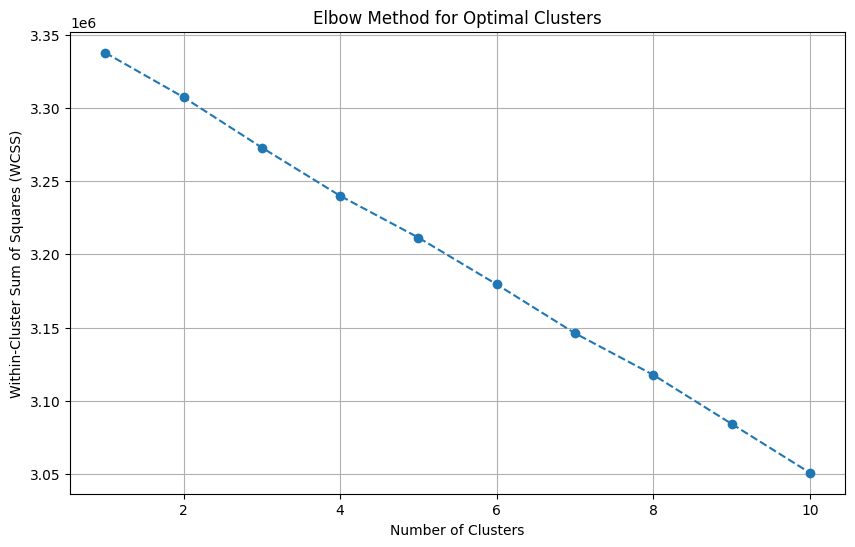

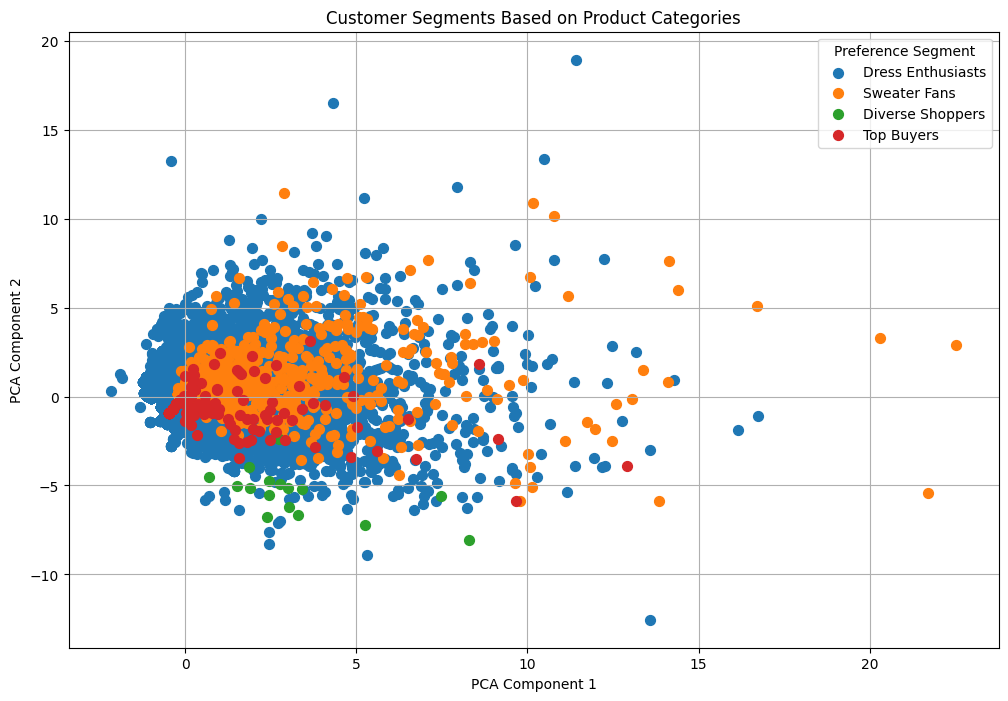

In [ ]:

# Merge datasets
order_product_df = pd.merge(order_df, product_df, on='product_id')
customer_order_product_df = pd.merge(order_product_df, customer_df, on='customer_userid')

# Create customer-product category matrix
# Group by customer_userid and product_category to calculate counts (or spending)
product_preferences = customer_order_product_df.groupby(['customer_userid', 'product_category']).size().unstack(fill_value=0)

# Normalize the data
scaler = StandardScaler()
product_preferences_scaled = scaler.fit_transform(product_preferences)

# Apply the Elbow Method to find the optimal number of clusters
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(product_preferences_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Clusters')
plt.grid()
plt.show()

# Apply K-Means with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
product_preferences['cluster'] = kmeans.fit_predict(product_preferences_scaled)

# Analyze cluster centers and assign labels
cluster_centers = kmeans.cluster_centers_
# print("Cluster Centers (scaled):", cluster_centers)

# Assign labels to clusters
labels = {
    1: "Dress Enthusiasts",
    0: "Sweater Fans",
    2: "Diverse Shoppers",
    3: "Top Buyers"
}
product_preferences['preference_segment'] = product_preferences['cluster'].map(labels)

# Save the results
product_preferences.reset_index(inplace=True)
product_preferences.to_csv('customer_product_category_segments.csv', index=False)

# Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(product_preferences_scaled)

plt.figure(figsize=(12, 8))
for cluster_id, label in labels.items():
    cluster_data = pca_result[product_preferences['cluster'] == cluster_id]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=label, s=50)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments Based on Product Categories')
plt.legend(title="Preference Segment")
plt.grid()
plt.show()


# Seasonal Customer Behavior
## Seasonal Features
- Seasonal features are extracted, including:
  - Holiday spending during November and December.
  - Non-holiday spending.
  - A `Holiday Ratio` feature emphasizing seasonal spending.

## Seasonal Clustering
- Customers are segmented based on their seasonal shopping behaviors using clustering.
- Cluster labels include:
  - Occasional Shoppers
  - Big Spenders
  - Holiday Shoppers
  - Year-Round Shoppers

## Visualization
- Scatter plots are used to display customer segments based on holiday and non-holiday spending patterns.

<ipython-input-10-aab9f21bec83>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_seasonal['holiday_ratio'].fillna(0, inplace=True)  # Handle cases where total_spending is 0


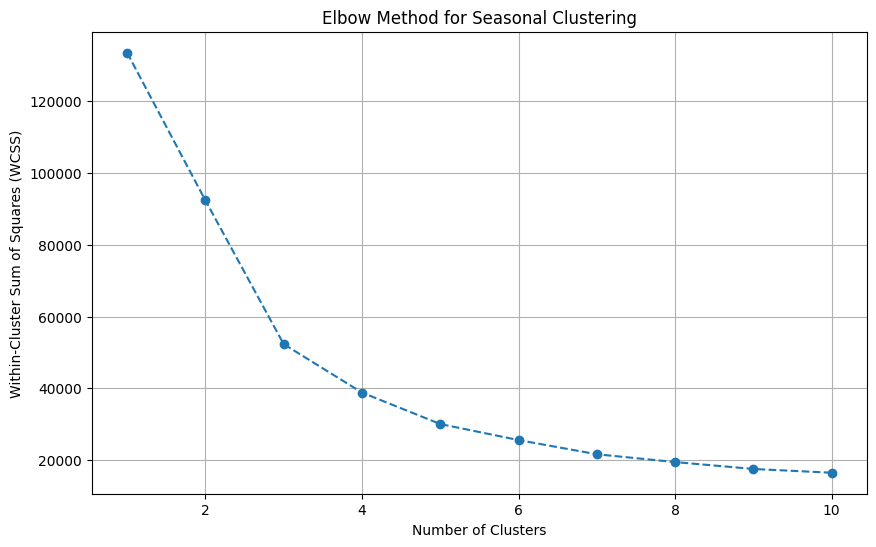

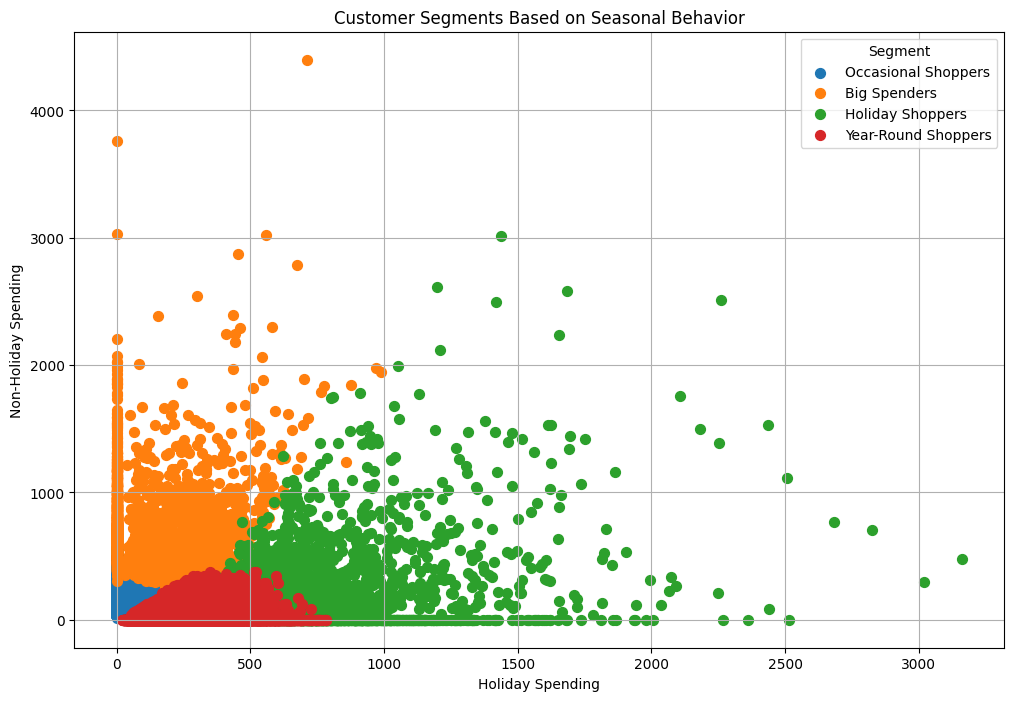

In [ ]:
# Convert 'order_date' to datetime format
order_df['order_date'] = pd.to_datetime(order_df['order_date'])

# Extract time-based features
order_df['month'] = order_df['order_date'].dt.month
order_df['is_holiday'] = order_df['order_date'].apply(lambda x: 1 if x.month in [11, 12] else 0)  # Holiday: Nov & Dec

# Aggregate customer data
customer_seasonal = order_df.groupby('customer_userid').agg(
    total_spending=('paid_amt', 'sum'),
    holiday_spending=('paid_amt', lambda x: x[order_df.loc[x.index, 'is_holiday'] == 1].sum()),
    non_holiday_spending=('paid_amt', lambda x: x[order_df.loc[x.index, 'is_holiday'] == 0].sum()),
    order_count=('order_id', 'count')
).reset_index()

# Replace NaN values (e.g., customers with no holiday spending) with 0
customer_seasonal.fillna(0, inplace=True)

# features for clustering
# Add a holiday_ratio feature to emphasize holiday spending
customer_seasonal['holiday_ratio'] = customer_seasonal['holiday_spending'] / customer_seasonal['total_spending']
customer_seasonal['holiday_ratio'].fillna(0, inplace=True)

# Re-weight holiday spending to give it more importance in clustering
customer_seasonal['weighted_holiday_spending'] = customer_seasonal['holiday_spending'] * 2

#Select features for clustering
features = ['weighted_holiday_spending', 'non_holiday_spending', 'holiday_ratio', 'order_count']
scaler = StandardScaler()
customer_seasonal_scaled = scaler.fit_transform(customer_seasonal[features])

#Use the Elbow Method to find the optimal number of clusters
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_seasonal_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Seasonal Clustering')
plt.grid()
plt.show()

# Step 7: Apply K-Means Clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_seasonal['cluster'] = kmeans.fit_predict(customer_seasonal_scaled)

#label clusters
cluster_centers = kmeans.cluster_centers_

# Assign labels based on cluster analysis
labels = {
    0: "Occasional Shoppers",
    1: "Big Spenders",
    2: "Holiday Shoppers",
    3: "Year-Round Shoppers"
}
customer_seasonal['segment'] = customer_seasonal['cluster'].map(labels)

# Save the results
customer_seasonal.to_csv('customer_seasonal_segments.csv', index=False)

# Visualize the clusters
plt.figure(figsize=(12, 8))
for cluster_id, label in labels.items():
    cluster_data = customer_seasonal[customer_seasonal['cluster'] == cluster_id]
    plt.scatter(cluster_data['holiday_spending'], cluster_data['non_holiday_spending'], label=label, s=50)

plt.xlabel('Holiday Spending')
plt.ylabel('Non-Holiday Spending')
plt.title('Customer Segments Based on Seasonal Behavior')
plt.legend(title="Segment")
plt.grid()
plt.show()
